In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

In [17]:
df = pd.read_csv("weather_data.csv")  # Adjust path accordingly

# Convert DAYTIME to datetime
df['DAYTIME'] = pd.to_datetime(df['DAYTIME'], format='%d.%m.%Y %H:%M:%S')

# Sort chronologically
df = df.sort_values('DAYTIME').reset_index(drop=True)

In [18]:
df['WD10M_rad'] = np.deg2rad(df['WD10M'])
df['WD10M_sin'] = np.sin(df['WD10M_rad'])
df['WD10M_cos'] = np.cos(df['WD10M_rad'])
df.drop(columns=['WD10M', 'WD10M_rad'], inplace=True)

In [19]:
df['hour'] = df['DAYTIME'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df.drop(columns=['hour'], inplace=True)

In [20]:
n = len(df)
train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


In [21]:
feature_columns = ['T2M', 'QV2M', 'PRECTOTCORR', 'PS', 'WS10M',
                   'WD10M_sin', 'WD10M_cos', 'hour_sin', 'hour_cos']
target_column = 'T2M'


In [22]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()

def scale(df):
    X = X_scaler.fit_transform(df[feature_columns])
    y = y_scaler.fit_transform(df[[target_column]])
    return X, y

X_train, y_train = scale(train_df)
X_val, y_val = scale(val_df)
X_test, y_test = scale(test_df)


In [23]:
def create_sequences(X, y, input_steps=168, output_steps=168):
    Xs, ys = [], []
    for i in range(len(X) - input_steps - output_steps):
        Xs.append(X[i:i+input_steps])
        ys.append(y[i+input_steps:i+input_steps+output_steps].flatten())
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_val_seq, y_val_seq = create_sequences(X_val, y_val)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)


In [24]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(168, len(feature_columns))),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(168)  # 168 time steps output
])

model.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 168, 256)       │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 168)            │        21,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,336 (1.25 MB)

 Trainable params: 327,336 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - RootMeanSquaredError: 0.4042 - loss: 0.1783 - val_RootMeanSquaredError: 0.2693 - val_loss: 0.0725
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - RootMeanSquaredError: 0.2580 - loss: 0.0666 - val_RootMeanSquaredError: 0.2604 - val_loss: 0.0678
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - RootMeanSquaredError: 0.2374 - loss: 0.0564 - val_RootMeanSquaredError: 0.2948 - val_loss: 0.0869
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - RootMeanSquaredError: 0.2211 - loss: 0.0489 - val_RootMeanSquaredError: 0.2869 - val_loss: 0.0823
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - RootMeanSquaredError: 0.1890 - loss: 0.0357 - val_RootMeanSquaredError: 0.3034 - val_loss: 0.0921
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - RootMeanSquaredError: 0.1686 - loss: 0.0284 - val_RootMeanSquaredError: 0.3088 - val_loss: 0.0954
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - RootMeanSquaredError

237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - RootMeanSquaredError: 0.3991 - loss: 0.1629
Test RMSE: 0.3446800112724304
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


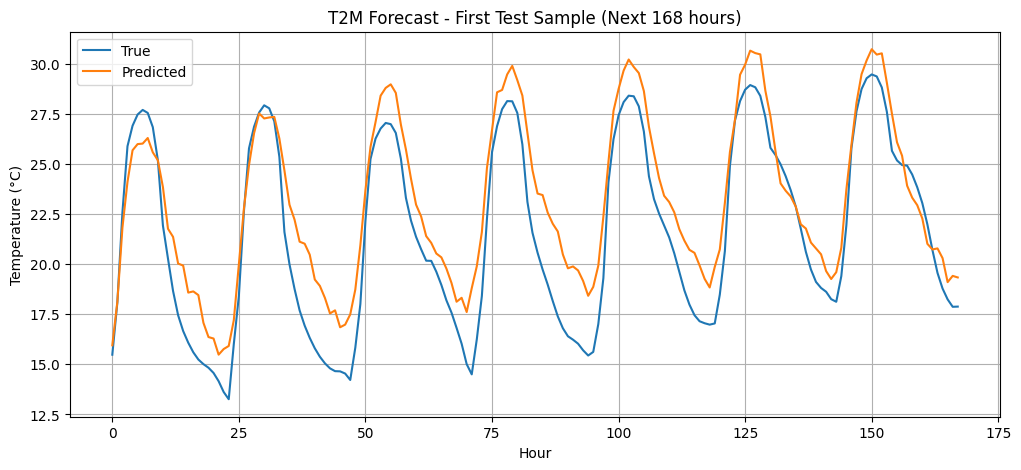

In [26]:
# Evaluate on test set
test_loss, test_rmse = model.evaluate(X_test_seq, y_test_seq)
print(f"Test RMSE: {test_rmse}")

# Inverse transform predictions
preds = model.predict(X_test_seq)
preds_inv = y_scaler.inverse_transform(preds)
true_inv = y_scaler.inverse_transform(y_test_seq)

# Plot example
plt.figure(figsize=(12, 5))
plt.plot(true_inv[0], label='True')
plt.plot(preds_inv[0], label='Predicted')
plt.title("T2M Forecast - First Test Sample (Next 168 hours)")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()
